In [1]:
from SimPEG import Mesh, Problem, Regularization, InvProblem, Optimization, Inversion, Directives, Utils, Maps,mkvc, DataMisfit
import SimPEG.PF as PF
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Maps.py:1663: FutureWarning: `ActiveCells` is deprecated and will be removed in future versions. Use `InjectActiveCells` instead
  FutureWarning)


Begin calculation of forward operator: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.20e+06  5.98e+03  0.00e+00  5.98e+03    4.73e+01      0              
   1  1.10e+06  5.66e+03  7.22e-05  5.74e+03    4.73e+01      0              
   2  5.50e+05  5.36e+03  2.72e-04  5.51e+03    4.73e+01      0   Skip BFGS  
   3  2.75e+05  4.85e+03

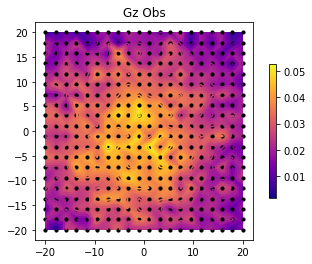

In [2]:
ndv = -100

# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 5), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 5), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 6)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-1]

# Go from topo to actv cells
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv, 1)
                  if elem], dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.ActiveCells(mesh, actv, -100)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = -np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1] + 5.

# Create a MAGsurvey
locXYZ = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseGrav.RxObs(locXYZ)
srcField = PF.BaseGrav.SrcField([rxLoc])
survey = PF.BaseGrav.LinearSurvey(srcField)

# We can now create a density model and generate data
# Here a simple block in half-space
model = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
model[(midx-2):(midx+2), (midy-2):(midy+2), -6:-2] = 0.5
model = mkvc(model)
model = model[actv]

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap,
                                     actInd=actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

# Add noise and uncertainties (1nT)
data = d + np.random.randn(len(d))*0.005
wd = np.ones(len(data))*.005

survey.dobs = data
survey.std = wd

PF.Gravity.plot_obs_2D(survey.srcField.rxList[0].locs,d=data)

# Create sensitivity weights from our linear forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5
wr = ( wr/np.max(wr) )

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
reg.norms = [0, 1, 1, 1]
reg.eps_p=1e-2
reg.eps_q=1e-2
    
# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=10,
                                 tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
IRLS = Directives.Update_IRLS(f_min_change=1e-3,
                              minGNiter=3)
update_Jacobi = Directives.Update_lin_PreCond()
inv = Inversion.BaseInversion(invProb,
                                   directiveList=[betaest, IRLS, 
                                                  update_Jacobi])

# Run the inversion
mrec = inv.run(model**0 * 1e-3)

residual = np.linalg.norm(mrec-model) / np.linalg.norm(model)


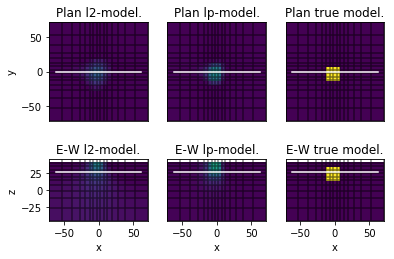

In [3]:
from ipywidgets.widgets import interact, IntSlider

# Here is the recovered susceptibility model
ypanel = midx
zpanel = -4
m_l2 = actvMap * IRLS.l2model
m_l2[m_l2==-100] = np.nan

m_lp = actvMap * mrec
m_lp[m_lp==-100] = np.nan

m_true = actvMap * model
m_true[m_true==-100] = np.nan

plt.figure()

#Plot L2 model
ax = plt.subplot(231)
mesh.plotSlice(m_l2, ax = ax, normal = 'Z', ind=zpanel, grid=True, clim = (0., model.max()),pcolorOpts={'cmap':'viridis'})
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([mesh.vectorCCy[ypanel],mesh.vectorCCy[ypanel]]),color='w')
plt.title('Plan l2-model.')
plt.gca().set_aspect('equal')
plt.ylabel('y')
ax.xaxis.set_visible(False)
plt.gca().set_aspect('equal', adjustable='box')

# Vertica section
ax = plt.subplot(234)
mesh.plotSlice(m_l2, ax = ax, normal = 'Y', ind=midx, grid=True, clim = (0., model.max()),pcolorOpts={'cmap':'viridis'})
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([mesh.vectorCCz[zpanel],mesh.vectorCCz[zpanel]]),color='w')
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([Z.min(),Z.max()]),color='k')
plt.title('E-W l2-model.')
plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

#Plot Lp model
ax = plt.subplot(232)
mesh.plotSlice(m_lp, ax = ax, normal = 'Z', ind=zpanel, grid=True, clim = (0., model.max()),pcolorOpts={'cmap':'viridis'})
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([mesh.vectorCCy[ypanel],mesh.vectorCCy[ypanel]]),color='w')
plt.title('Plan lp-model.')
plt.gca().set_aspect('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.gca().set_aspect('equal', adjustable='box')


# Vertical section
ax = plt.subplot(235)
mesh.plotSlice(m_lp, ax = ax, normal = 'Y', ind=midx, grid=True, clim = (0., model.max()),pcolorOpts={'cmap':'viridis'})
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([mesh.vectorCCz[zpanel],mesh.vectorCCz[zpanel]]),color='w')
plt.title('E-W lp-model.')
plt.gca().set_aspect('equal')
ax.yaxis.set_visible(False)
plt.xlabel('x')
plt.gca().set_aspect('equal', adjustable='box')

#Plot True model
ax = plt.subplot(233)
mesh.plotSlice(m_true, ax = ax, normal = 'Z', ind=zpanel, grid=True, clim = (0., model.max()),pcolorOpts={'cmap':'viridis'})
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([mesh.vectorCCy[ypanel],mesh.vectorCCy[ypanel]]),color='w')
plt.title('Plan true model.')
plt.gca().set_aspect('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.gca().set_aspect('equal', adjustable='box')


# Vertical section
ax = plt.subplot(236)
mesh.plotSlice(m_true, ax = ax, normal = 'Y', ind=midx, grid=True, clim = (0., model.max()),pcolorOpts={'cmap':'viridis'})
plt.plot(([mesh.vectorCCx[0],mesh.vectorCCx[-1]]),([mesh.vectorCCz[zpanel],mesh.vectorCCz[zpanel]]),color='w')
plt.title('E-W true model.')
plt.gca().set_aspect('equal')
plt.xlabel('x')
ax.yaxis.set_visible(False)
plt.gca().set_aspect('equal', adjustable='box')